### In this notebook, we apply `popsed` to GAMA photometry catalog.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [3]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

noise = 'gama_snr'
noise_model_dir = './noise_model/gama_snr_model_mag_dr4_gkv.npy'

In [23]:
test_par = torch.Tensor([[.1, 0.1, 0.1, 0.0, 4, -1.3, 1.2, 1.2, 0, 0.01, 7.0],
                         [0.5, 0.5, 0.5, 0.5, 4, -1.3, 1.2, 1.2, 0, 0.3, 10.0]]).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(test_par, noise=noise, 
                                                  SNR=torch.Tensor([1, 1, 1, 1, 1]).to('cuda'),
                                           noise_model_dir=noise_model_dir)
mags

tensor([[23.3492, 21.8213, 21.1885, 20.8368, 20.6045],
        [23.3689, 24.2742, 22.2273, 21.8850, 21.4531]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [9]:
### VIKING filters: http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set

#### Load GAMA photometry catalog

In [28]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [49]:
X_data = np.load('./reference_catalog/GAMA/gama_clean_mag_dr4_gkv.npy')[:, :5]
X_data = X_data[np.random.randint(len(X_data), size=(100000))]
print('Total number of samples:', len(X_data))

Total number of samples: 100000


In [50]:
from itertools import combinations
from torch.utils.data import DataLoader
import gc

In [ ]:
scaler = StandardScaler(device='cpu')
scaler.fit(X_data)
_X_data = scaler.transform(X_data)
# Determine the intrinsic sampling loss
X_datas = []
for i in range(5):
    ind = np.random.randint(0, len(_X_data), 10000)
    X_datas.append(torch.Tensor(_X_data[ind]).to('cuda'))
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.002, 'scaling': 0.9})
intr_loss = []
for i in range(5):
    dataloader = DataLoader(_X_data, batch_size=10000, shuffle=True)
    data_loss = 0.
    for x in dataloader:
        data_loss += L(X_datas[i], x.to('cuda'))
    loss = data_loss / len(dataloader)
    intr_loss.append(loss.item())

print("Intrinsic sampling loss:", np.mean(intr_loss), '+-', np.std(intr_loss))
del X_datas
gc.collect()
torch.cuda.empty_cache()

In [51]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [52]:
_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0, 1]) # np.array([0.15, 0.35])
_prior_NDE[-1] = np.array([7.5, 13.])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

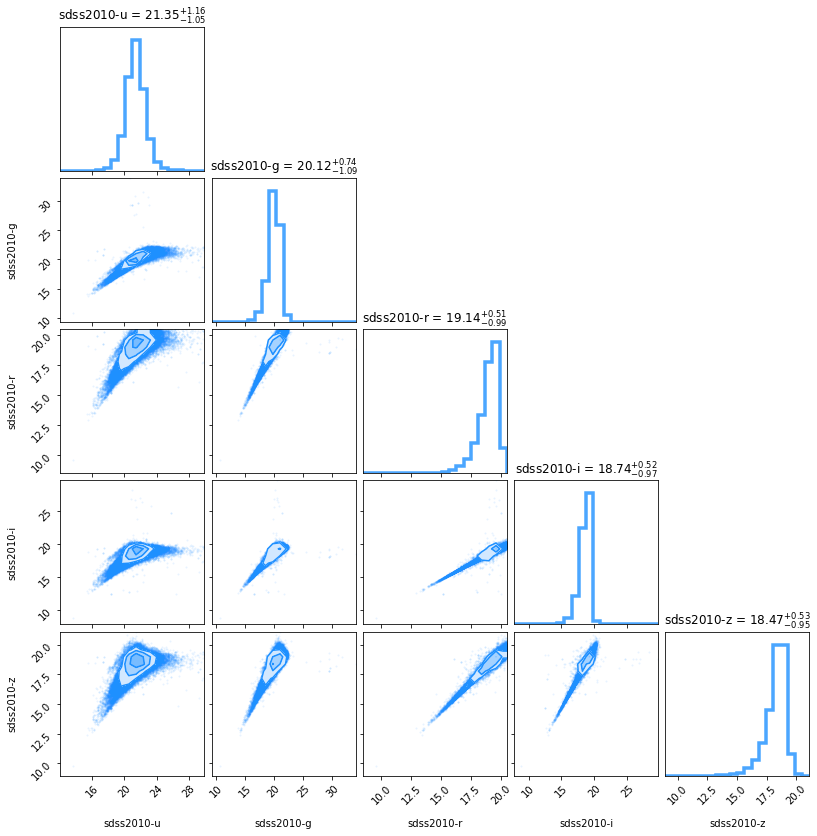

In [53]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(X_data,#.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [54]:
X_train, X_vali = train_test_split(X_data, test_size=0.15)
if name == 'NMF_ZH':
    Y_train = torch.ones(len(X_train), 12)
else:
    Y_train = torch.ones(len(X_train), 11)

### now we provide the redshift distribution to it

In [55]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [56]:
seed = 1
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 10), 
                   np.abs(np.random.normal(size=len(_bounds)) / 10)]).T

_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name=name,
                                              num_transforms=20,  # 10
                                              num_bins=60,  # how smashed it is. 10
                                              hidden_features=100,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )

In [57]:
NDE_theta.build(
    Y_train,
    X_train,
    filterset=gama_filters,
    z_score=True,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

NDE_theta.external_redshift_data = None

[-0.00878336  0.00611517 -0.05280674 -0.04057998 -0.05769884 -0.20730961
 -0.12563127 -0.04835763  0.00387874  0.04780266 -0.03693384]
Total number of params in the model: 2812330


In [58]:
# NDE_theta.noise_scaling
# NDE_theta.optimizer.add_param_group({'params': NDE_theta.noise_scaling})

In [59]:
# del X_data
gc.collect()
torch.cuda.empty_cache()

In [60]:
# noise = 'gama_snr'
# noise_model_dir = './noise_model/gama_snr_model_mag_dr3_apmatch.npy'
max_epochs = 40
anneal_tau = 12
anneal_coeff = 20
max_lr = 3e-4
NDE_theta.output_dir = "./NDE/GAMA/anneal/real/test_dr4_gkv/"

blurs = [0.3, 0.3, 0.2, 0.2, 0.1, 0.1,
         0.1, 0.05, 0.05, 0.05] + [0.002] * max_epochs
snrs = [1 + anneal_coeff * np.exp(- anneal_tau / max_epochs * i)
        for i in range(max_epochs)]  # larger anneal_coeff, after annealing
steps = 20

snrs = np.repeat(np.array(snrs)[:, None], 5, axis=1)

# blurs = [0.3, 0.3, 0.2, 0.2, 0.1, 0.1,
#          0.1, 0.05, 0.05, 0.05] + [0.002] * max_epochs
# temp = [2 + anneal_coeff * np.exp(- anneal_tau / max_epochs * i)
#         for i in range(max_epochs)]  # larger anneal_coeff, after annealing

# snrs = np.hstack([np.array(temp)[:, None], snrs])
snrs = torch.Tensor(snrs).to('cuda')

In [ ]:
try:
    print('### Training NDE for seed {0}'.format(seed))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                    max_lr=max_lr,
                                                    steps_per_epoch=steps,
                                                    epochs=max_epochs)
    for i, epoch in enumerate(range(max_epochs)):
        np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
                NDE_theta.sample(5000).detach().cpu().numpy())

        print('    Epoch {0}'.format(epoch))
        print('\n\n')
        print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'], '  blurs:', blurs[i])
#         print('    noise_scaling:', 10**(NDE_theta.noise_scaling.detach().cpu().numpy()))
        NDE_theta.train(n_epochs=steps,
                        speculator=speculator,
                        add_penalty=False,
                        n_samples=10000,
                        noise=noise,
                        noise_model_dir=noise_model_dir,
                        SNR=snrs[i],
                        sinkhorn_kwargs={
                            'p': 1, 'blur': blurs[i], 'scaling': 0.9},
                        scheduler=scheduler
                        )

    print(f'    Succeeded in training for {max_epochs} epochs!')
    print('    Saving NDE model for seed {0}'.format(seed))
    print('\n\n')
    np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
            NDE_theta.sample(5000).detach().cpu().numpy())
    NDE_theta.save_model(
        os.path.join(NDE_theta.output_dir,
                     f'nde_theta_last_model_{NDE_theta.method}_{NDE_theta.seed}.pkl')
    )
except Exception as e:
    print(e)

### Training NDE for seed 1
    Epoch 0



    lr: 1.200000000000002e-05   blurs: 0.3


Loss = 10.256 (train), 10.285 (vali), 0.017 (bad ratio): 100%|████████████████████████| 20/20 [02:13<00:00,  6.67s/epochs]


    Epoch 1



    lr: 1.6947589760522874e-05   blurs: 0.3


Loss = 9.081 (train), 9.123 (vali), 0.005 (bad ratio): 100%|██████████████████████████| 20/20 [02:14<00:00,  6.71s/epochs]


    Epoch 2



    lr: 3.1450377869335464e-05   blurs: 0.2


Loss = 7.394 (train), 7.369 (vali), 0.004 (bad ratio): 100%|██████████████████████████| 20/20 [02:20<00:00,  7.02s/epochs]


    Epoch 3



    lr: 5.451178313274071e-05   blurs: 0.2


Loss = 4.619 (train), 4.474 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [02:18<00:00,  6.93s/epochs]


    Epoch 4



    lr: 8.454710593206496e-05   blurs: 0.1


Loss = 2.333 (train), 2.332 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [02:26<00:00,  7.33s/epochs]


    Epoch 5



    lr: 0.00011949242327375373   blurs: 0.1


Loss = 0.724 (train), 0.736 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [02:23<00:00,  7.16s/epochs]


    Epoch 6



    lr: 0.00015694641440422414   blurs: 0.1


Loss = 0.278 (train), 0.286 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [02:20<00:00,  7.04s/epochs]


    Epoch 7



    lr: 0.00019433537122614522   blurs: 0.05


Loss = 0.225 (train), 0.226 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [02:28<00:00,  7.41s/epochs]


    Epoch 8



    lr: 0.00022909005457383963   blurs: 0.05


Loss = 0.161 (train), 0.169 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [02:33<00:00,  7.67s/epochs]


    Epoch 9



    lr: 0.0002588222433992343   blurs: 0.05


Loss = 0.145 (train), 0.145 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [02:31<00:00,  7.60s/epochs]


    Epoch 10



    lr: 0.0002814888450219061   blurs: 0.002


Loss = 0.206 (train), 0.217 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:15<00:00,  9.80s/epochs]


    Epoch 11



    lr: 0.00029553228935721374   blurs: 0.002


Loss = 0.190 (train), 0.199 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:16<00:00,  9.83s/epochs]


    Epoch 12



    lr: 0.0002999976396191713   blurs: 0.002


Loss = 0.205 (train), 0.208 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:16<00:00,  9.80s/epochs]


    Epoch 13



    lr: 0.00029896027270216475   blurs: 0.002


Loss = 0.214 (train), 0.212 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:16<00:00,  9.82s/epochs]


    Epoch 14



    lr: 0.0002960496514725132   blurs: 0.002


Loss = 0.191 (train), 0.188 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:15<00:00,  9.77s/epochs]


    Epoch 15



    lr: 0.0002913023786809613   blurs: 0.002


Loss = 0.197 (train), 0.200 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:16<00:00,  9.80s/epochs]


    Epoch 16



    lr: 0.00028477815403729455   blurs: 0.002


Loss = 0.188 (train), 0.188 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:16<00:00,  9.80s/epochs]


    Epoch 17



    lr: 0.0002765590234518506   blurs: 0.002


Loss = 0.163 (train), 0.172 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:15<00:00,  9.76s/epochs]


    Epoch 18



    lr: 0.00026674834726059184   blurs: 0.002


Loss = 0.160 (train), 0.166 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:16<00:00,  9.82s/epochs]


    Epoch 19



    lr: 0.0002554695004089104   blurs: 0.002


Loss = 0.168 (train), 0.175 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:16<00:00,  9.80s/epochs]


    Epoch 20



    lr: 0.00024286432094010554   blurs: 0.002


Loss = 0.157 (train), 0.168 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:15<00:00,  9.78s/epochs]


    Epoch 21



    lr: 0.00022909132629969284   blurs: 0.002


Loss = 0.159 (train), 0.168 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:14<00:00,  9.73s/epochs]


    Epoch 22



    lr: 0.00021432371988655327   blurs: 0.002


Loss = 0.155 (train), 0.163 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:15<00:00,  9.78s/epochs]


    Epoch 23



    lr: 0.00019874721291969675   blurs: 0.002


Loss = 0.159 (train), 0.164 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:15<00:00,  9.77s/epochs]


    Epoch 24



    lr: 0.00018255768901193146   blurs: 0.002


Loss = 0.153 (train), 0.161 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:15<00:00,  9.77s/epochs]


    Epoch 25



    lr: 0.0001659587408197781   blurs: 0.002


Loss = 0.163 (train), 0.170 (vali), 0.000 (bad ratio): 100%|██████████████████████████| 20/20 [03:14<00:00,  9.73s/epochs]


    Epoch 26



    lr: 0.00014915910974768704   blurs: 0.002


Loss = 0.160 (train), 0.163 (vali), 0.000 (bad ratio):  65%|████████████████▉         | 13/20 [02:16<01:07,  9.63s/epochs]

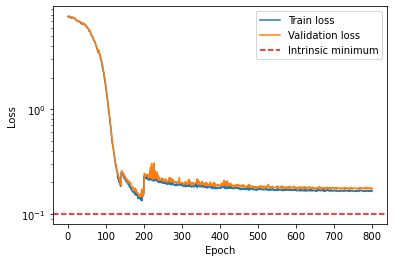

In [166]:
NDE_theta.plot_loss(0.1)
plt.yscale('log')

In [173]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

# NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
# NDE_theta.goodness_of_fit(Y_truth, p=1)

Best epoch: 415
Best train loss: 0.026043515652418137
Best vali loss: 0.023706652224063873


In [167]:
from popsed.nde import transform_nmf_params_given_z, inverse_transform_nmf_params_given_z

In [82]:
samples = NDE_theta.sample(4000)

4 4000
>40 0


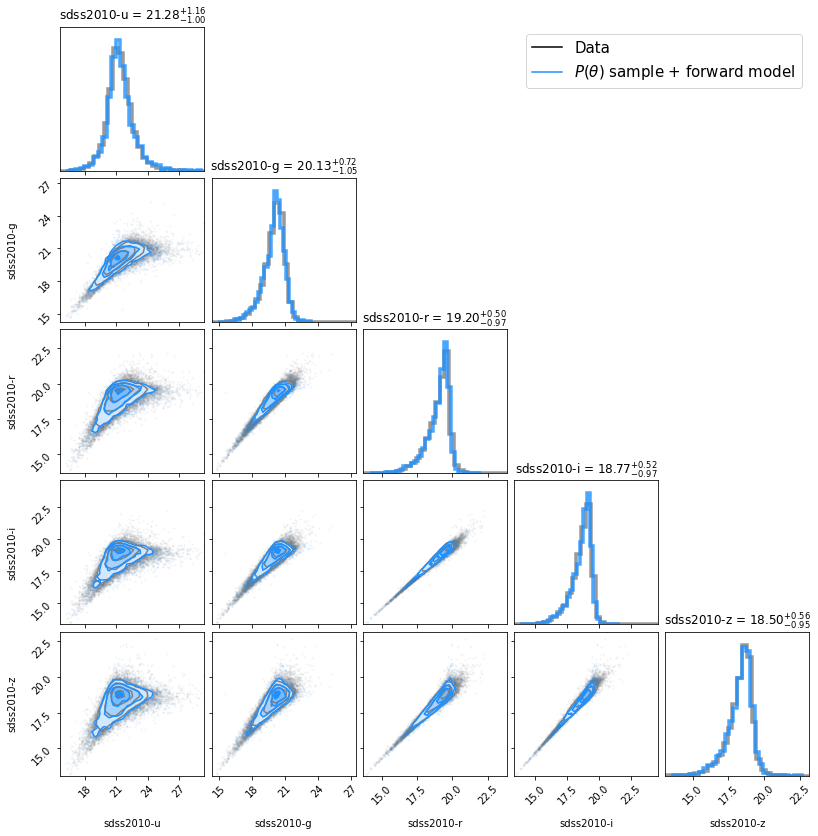

In [83]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=30,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir, 
                                                  SNR=1, noise_scaling=-0.0065,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [119]:
NDE_theta.noise_scaling

tensor([0.8224], device='cuda:0', requires_grad=True)

In [267]:
mags = speculator._predict_mag_with_mass_redshift(
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir, 
    SNR=10000000
                                                  ).cpu().detach().numpy()

In [268]:
mags

array([[20.023983, 18.7892  , 18.214619, 17.869358, 17.625051],
       [20.131857, 18.881046, 18.283367, 18.022566, 17.76339 ],
       [23.765747, 21.122725, 19.54168 , 18.892906, 18.492168],
       ...,
       [21.4867  , 20.188124, 19.19748 , 18.758595, 18.357338],
       [24.606274, 21.734737, 19.711063, 19.001614, 18.591267],
       [20.870485, 19.164255, 18.159786, 17.703117, 17.362005]],
      dtype=float32)

In [302]:
maggies = 10**(-0.4 * mags)

In [322]:
maggies_new = speculator._add_photometry_noise(
            torch.Tensor(maggies).to('cuda'), 
    noise=noise, noise_model_dir=noise_model_dir, SNR=1).cpu().detach().numpy()
mags_new = -2.5 * np.log10(maggies_new)

In [323]:
np.sum(maggies_new < 0)

0

Text(0.5, 0, 'u mag')

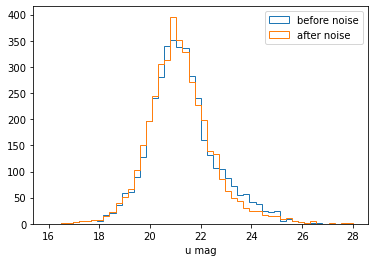

In [330]:
plt.hist(-2.5 * np.log10(maggies[:, 0]), bins=50, range=(16, 28), histtype='step', label='before noise')
plt.hist(-2.5 * np.log10(maggies_new[:, 0]), bins=50, range=(16, 28), histtype='step', label='after noise')

# plt.hist(X_data[:, 0], bins=50, range=(16, 28), histtype='step', label='after noise', density=True)


plt.legend()
plt.xlabel('u mag')
# plt.yscale('log')

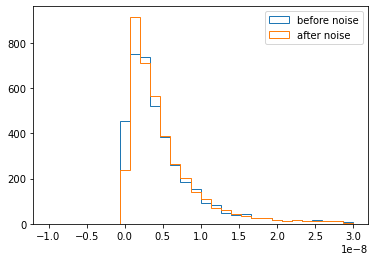

In [295]:
plt.hist(maggies[:, 0], bins=30, range=(-1e-8, 3e-8), histtype='step', label='before noise')
plt.hist(maggies_new[:, 0], bins=30, range=(-1e-8, 3e-8), histtype='step', label='after noise')

plt.legend()
# plt.xscale('log')

In [84]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                      _samples_unt[:, 3:-1], 
                      _samples_unt[:, -1:]])

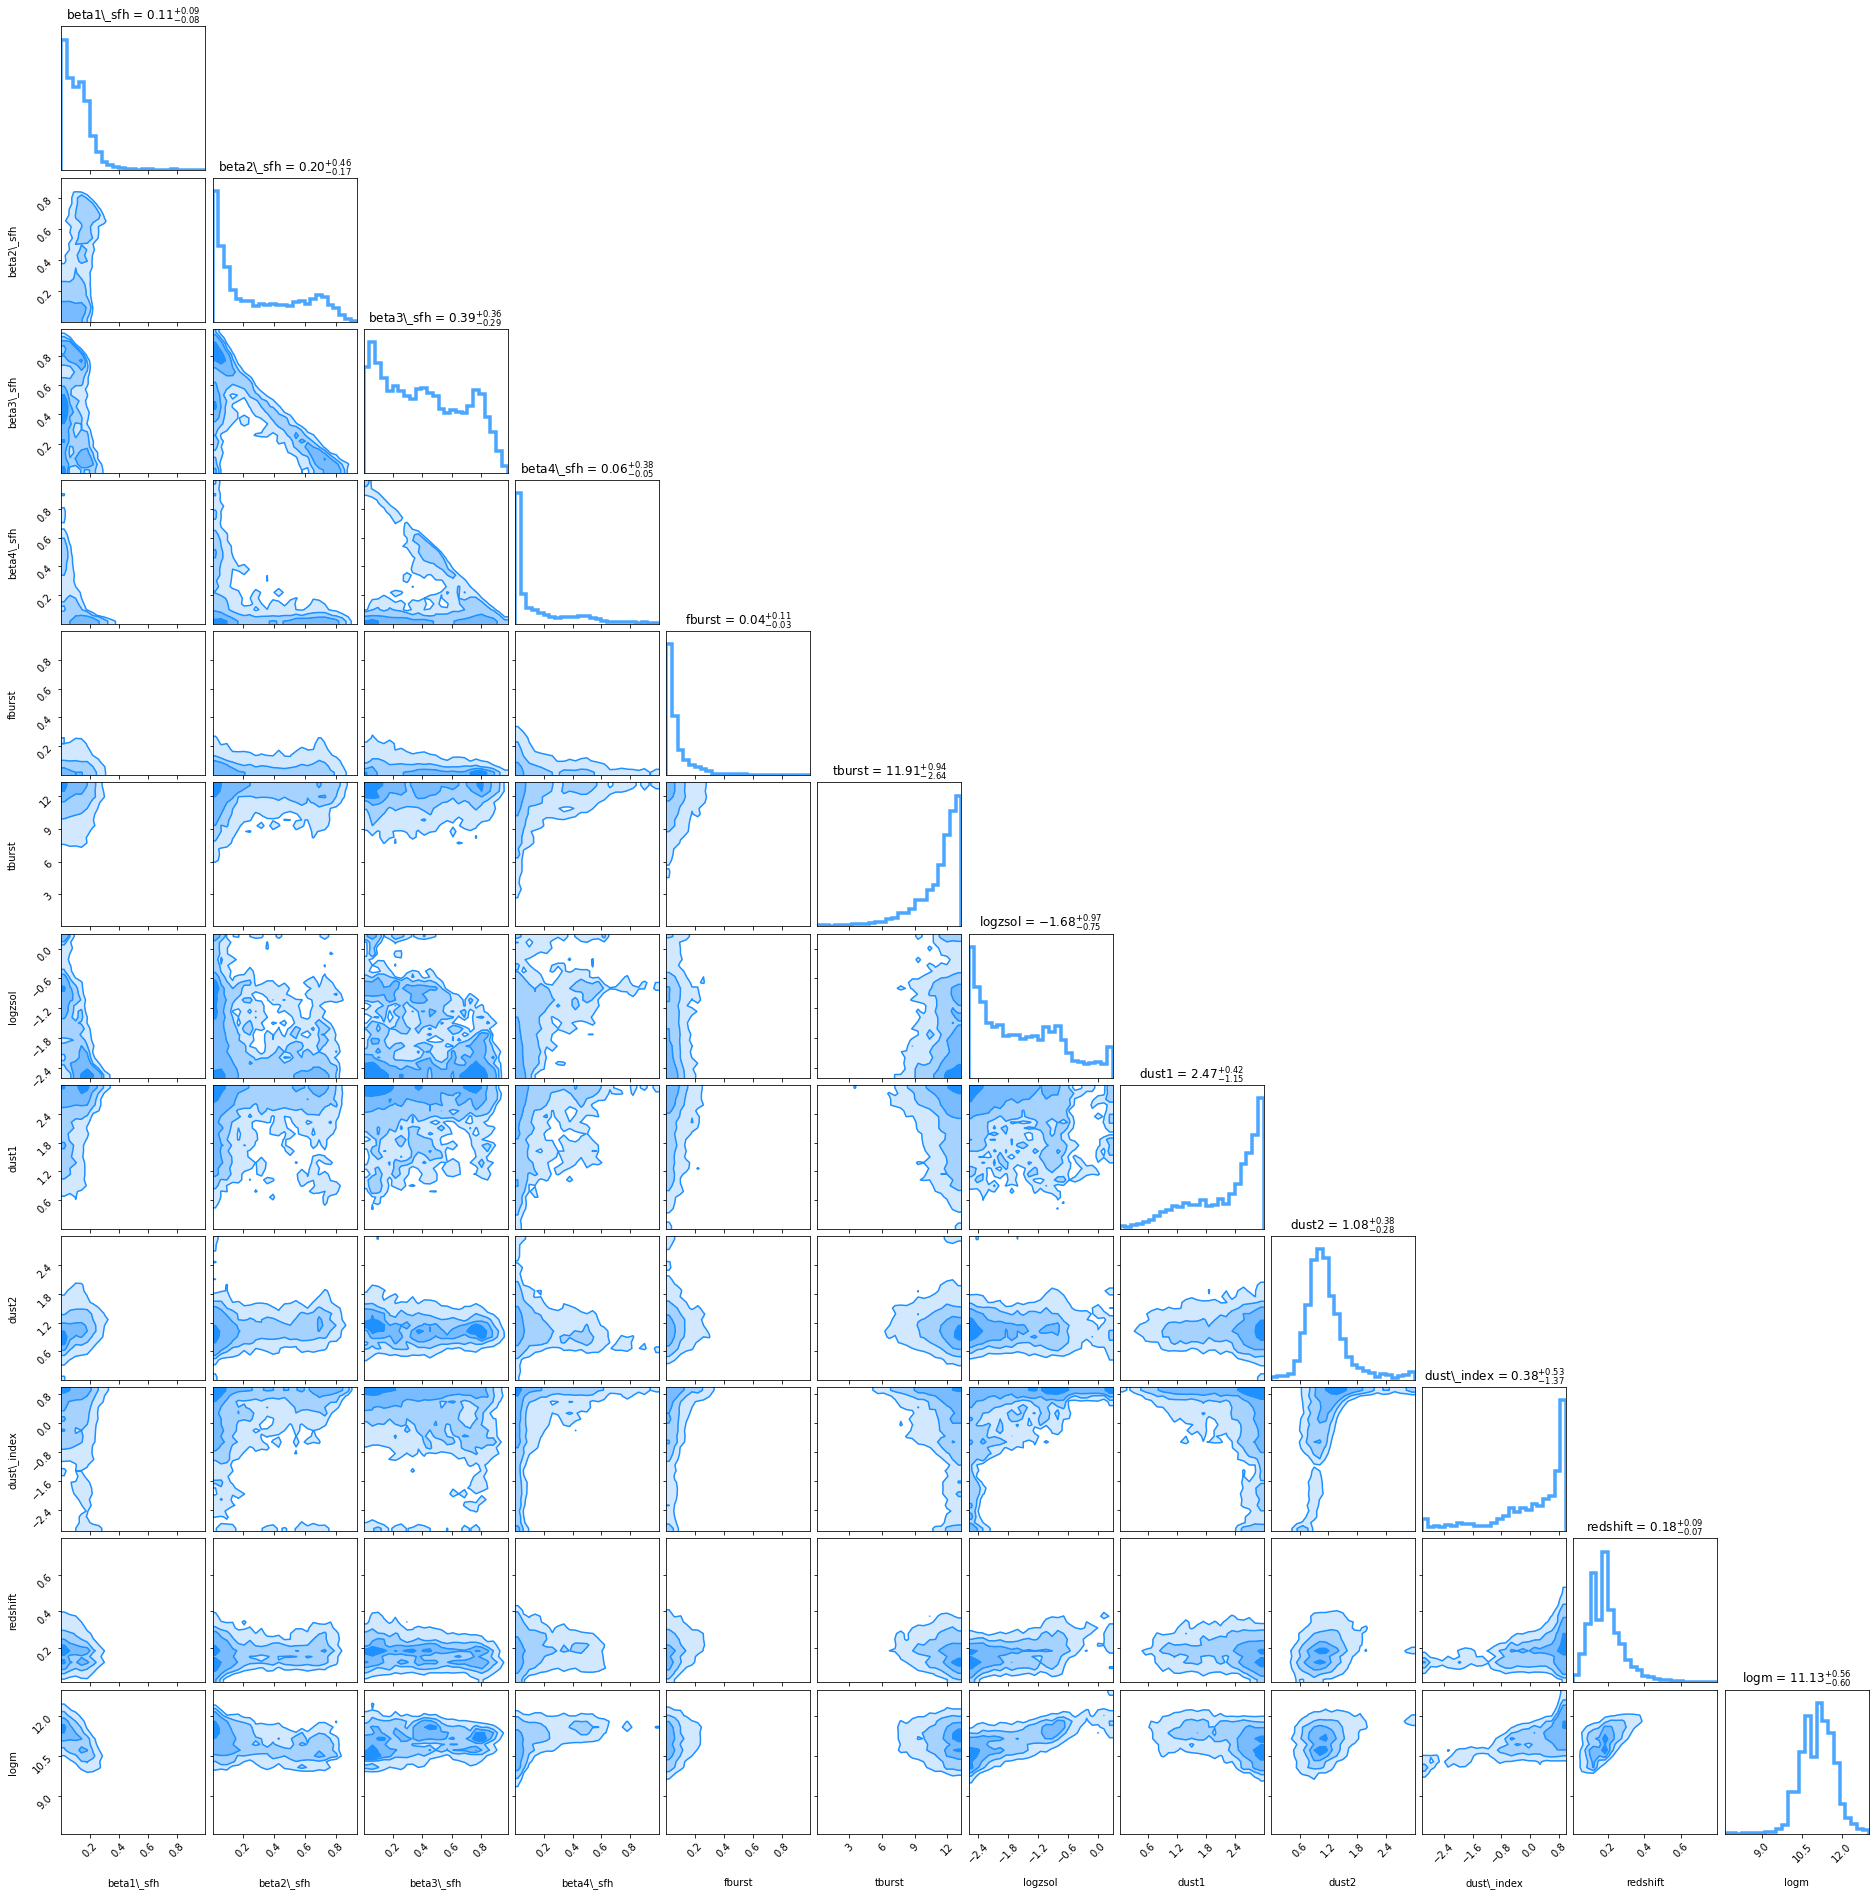

In [173]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [85]:
z_mass_met = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_lambdar.npy')

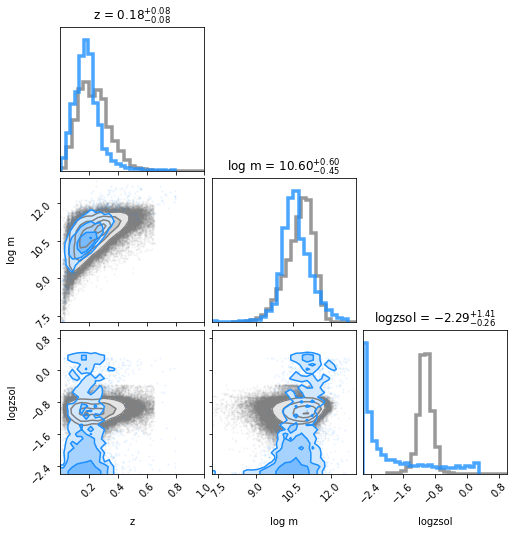

In [86]:
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                       range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:] - 0.3, _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

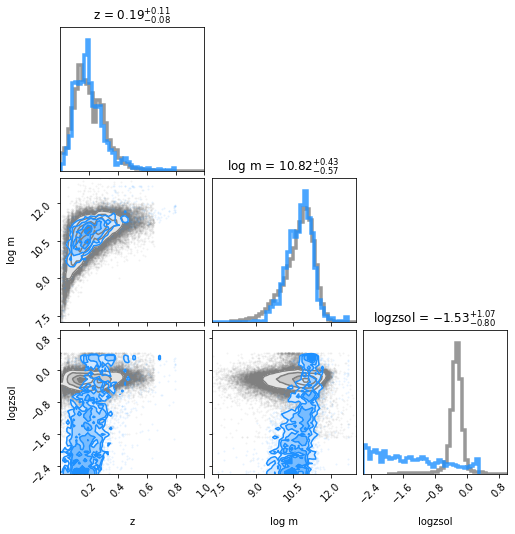

In [44]:
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=40,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                       range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:] - 0.3, _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [64]:
from popsed.models import NMF_ZH
model = NMF_ZH(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [63]:
params = np.hstack([_samples[:, -1:], _samples[:, :-1]])

In [69]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))
zmw = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=tt[-1], dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=tt[-1])
    zmw[i] = model.Z_MW(tt[:-1], zred=tt[-1])

In [78]:
redshift = params[:, -1]
logmstar = params[:, 0]
logzsol = np.log10(zmw / 0.019)

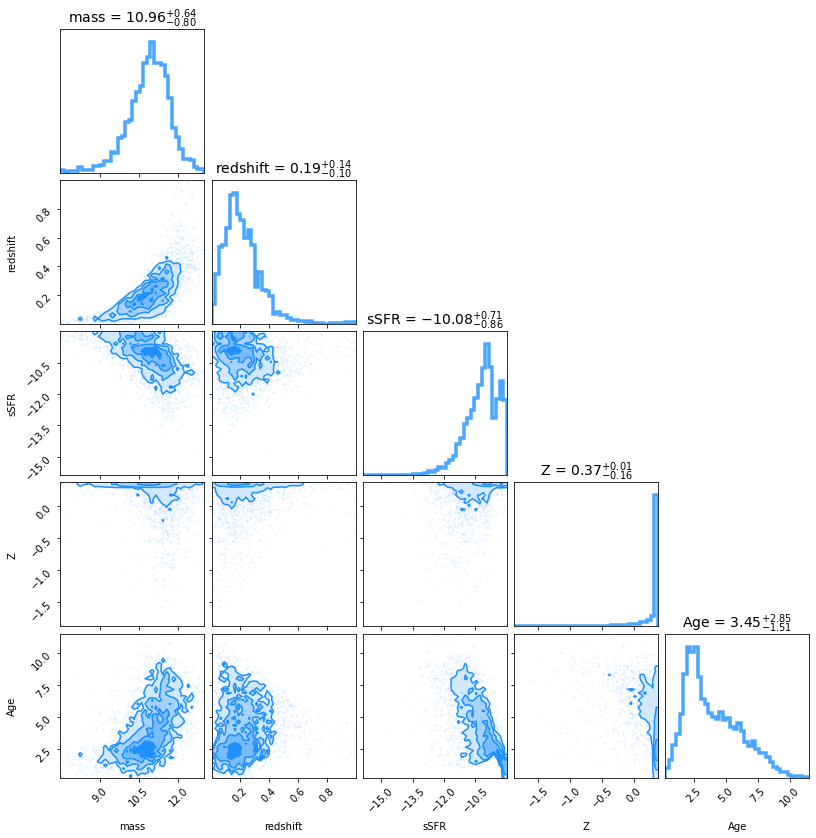

In [79]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['mass','redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [35]:
a, b = np.histogram(z_mass_truth[:, 0].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.15714286

In [31]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()

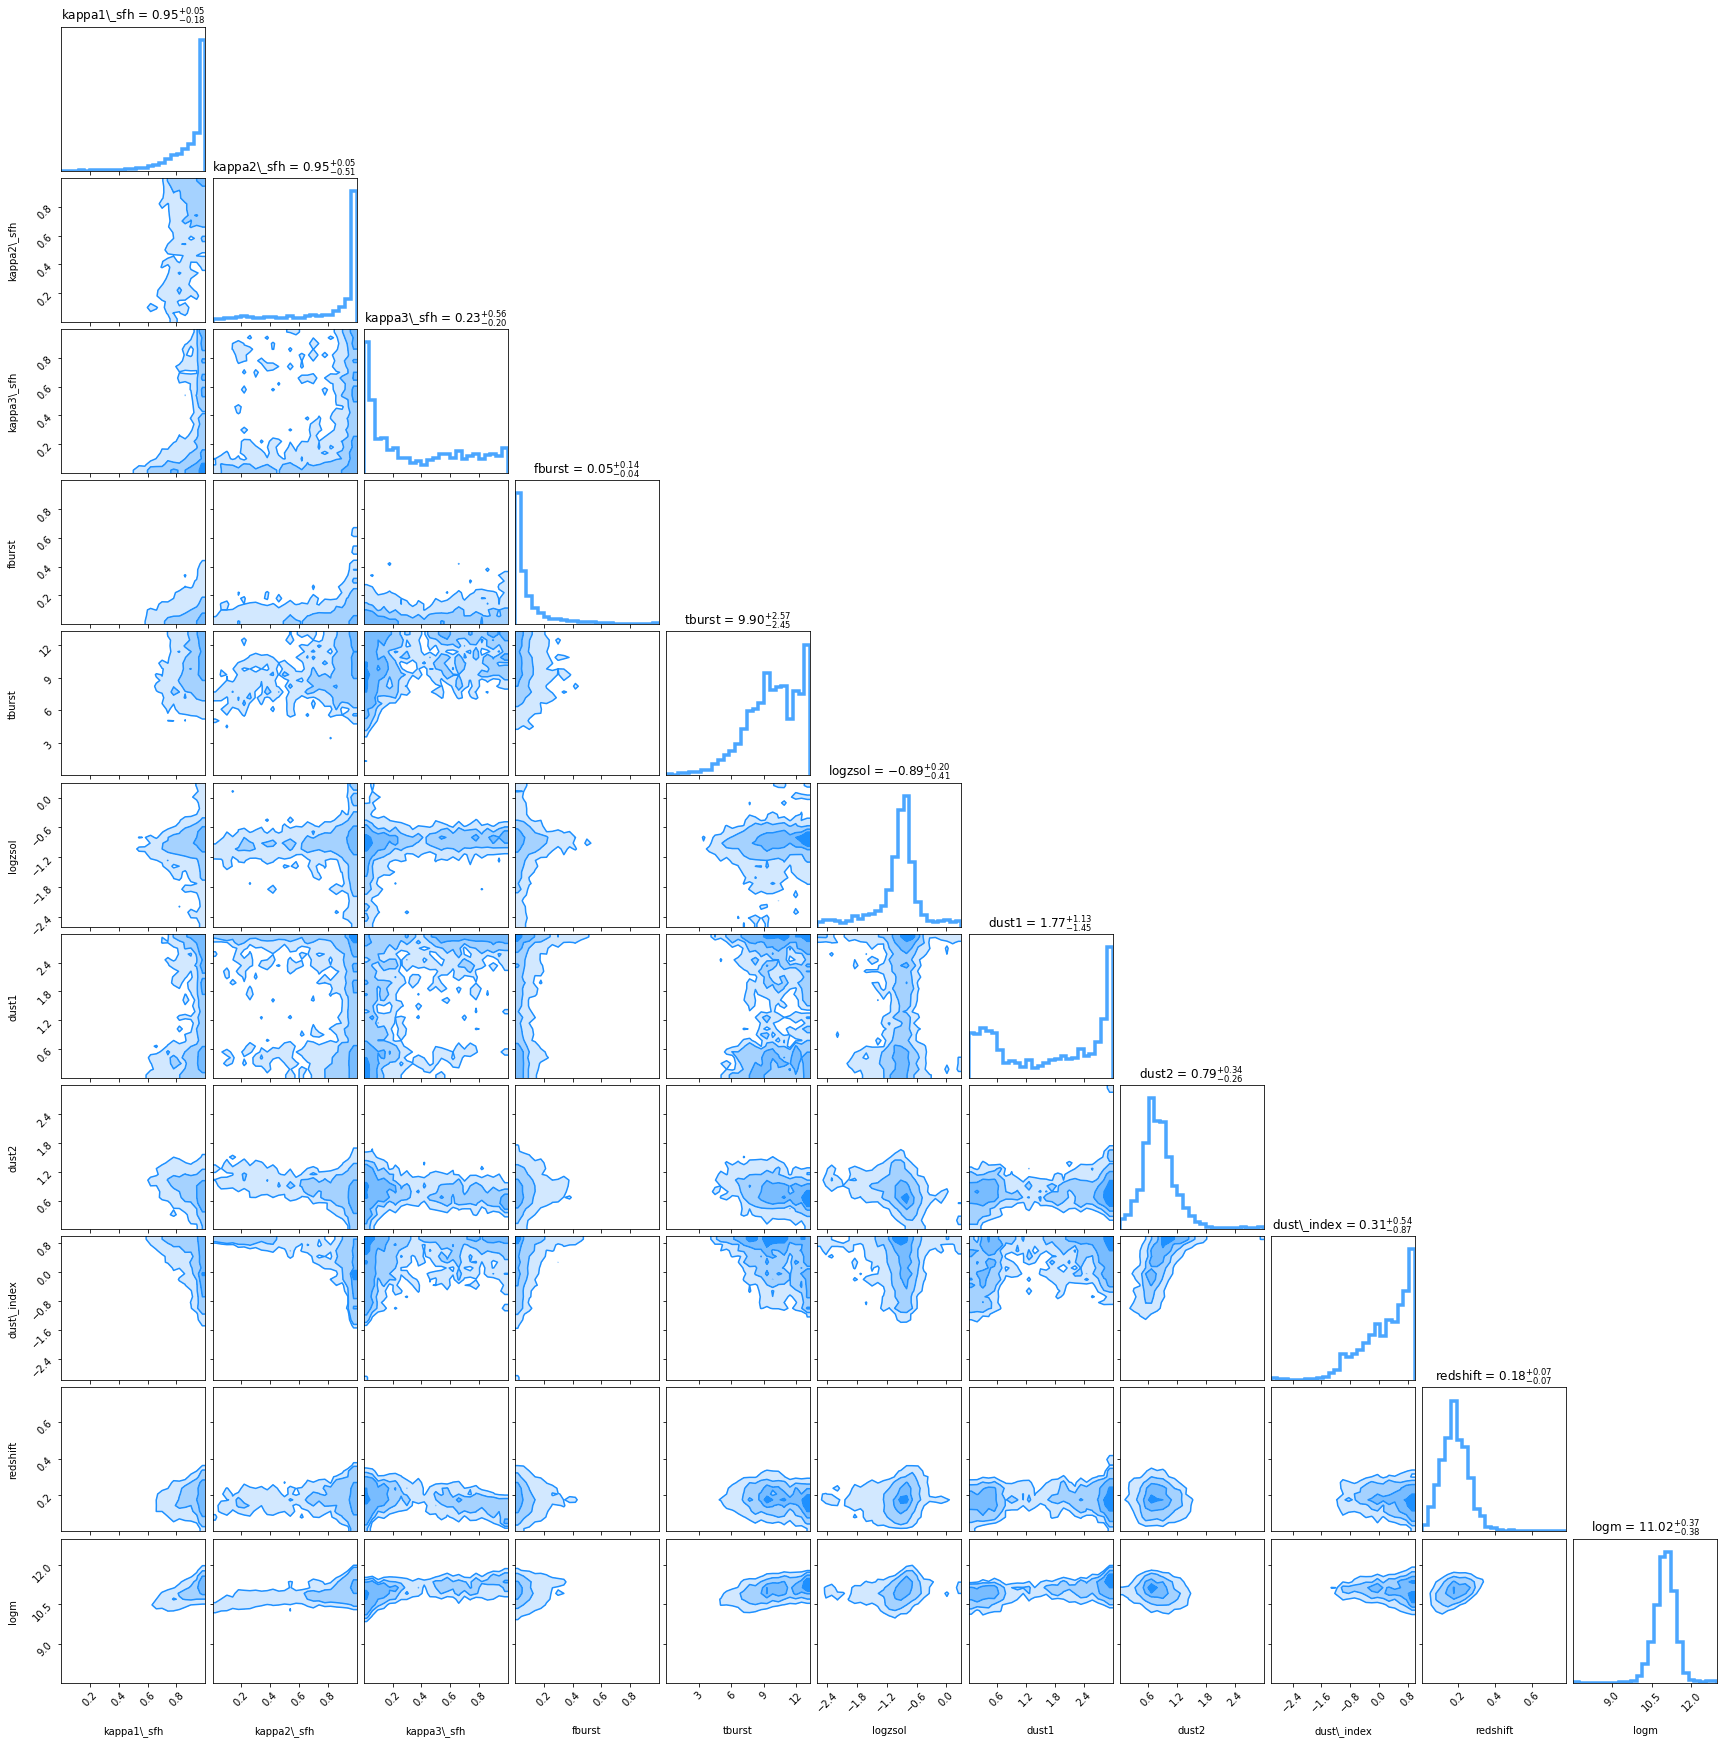

In [32]:
_labels = [f'kappa{i}_sfh' for i in range(1,4)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples_unt, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))